In [1]:
import fitz
import re
import os
import pandas as pd
import tiktoken
from matplotlib import pyplot as plt
import openai
import httpx
from collections import defaultdict
from prompts import  ENTITY_EXTRACTION_PROMPT, COMMUNITY_SUMMARIZATION_PROMPT, \
                    PREDICTION_PROMPT, ENTITY_DESCRIPTION_SUMMARIZATION_PROMPT, \
                    RELATIONSHIP_SUMMARIZATION_PROMPT
from tqdm import tqdm
import numpy as np
import ollama
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity
from collections import deque
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma
from langchain.schema import Document
from graspologic.partition import hierarchical_leiden, leiden
import networkx as nx
from itertools import combinations
import json
import copy
from langchain_text_splitters import RecursiveCharacterTextSplitter
from networkx.readwrite import json_graph

#### Creating chunks

In [11]:
# defining text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,
)

# creating chunks from documnet
docname = "Astez Lifesciences Ltd.pdf"
doc = fitz.Document(docname)
pages = doc.page_count
chunks = []
for pageno in range(pages):
    page = doc.load_page(pageno)
    pagetext = page.get_text("text")
    pagetext = re.sub(r" +", r" ", pagetext)
    texts = text_splitter.create_documents([pagetext])
    for txt in texts:
        chunks.append(txt.page_content)
    chunks.append(pagetext)

In [12]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
chunk_tok = []
for x in chunks:
    chunk_tok.append(len(encoding.encode(x)))

len(chunks)

334

(array([11., 18., 33., 75., 97., 59., 26.,  9.,  5.,  1.]),
 array([   0. ,  146.3,  292.6,  438.9,  585.2,  731.5,  877.8, 1024.1,
        1170.4, 1316.7, 1463. ]),
 <BarContainer object of 10 artists>)

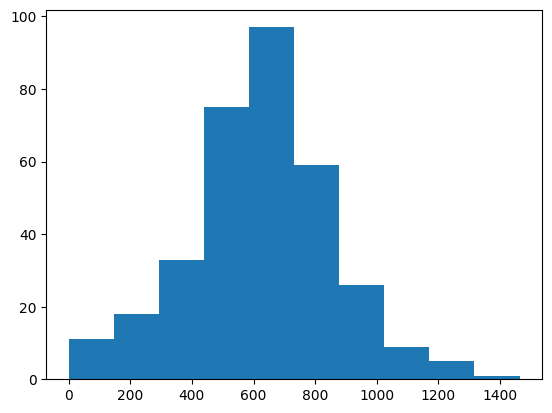

In [13]:
plt.hist(chunk_tok)

#### Extracting entities from chunks

In [15]:
# defining entity types
entity_types = ["Scope 1 Emmission", "Scope 2 Emmission", "Scope 3 Emmission", "Energy reduction", "Co2", 
                "Operational emmision", "Carbon",
                "Carbon Emmision reduction", "Target Announcement Year", "Target Baseline Year", 
                "Target End/ Horizon Year", "Percentage Reduction (%)", 
                "Percentage Reduction comprising Carbon Offsets or Carbon Removals (%)", 
                "Details of Carbon Offsets or Carbon Removals to be used", 
                "Target Type (Absolute, Intensity, or Other)(Please specify further detail if Other)", 
                "Target Units (Relevant for 'Intensity' target type)"]

In [16]:
# defining OpenAi client
client = openai.AsyncAzureOpenAI(
    azure_endpoint='***',
    api_key='***',
    api_version='***',
    http_client =  httpx.AsyncClient(verify=False)
)

# Extracting entitites and relationships for Knowledge Graph
chunk_rel_dct = defaultdict(list)
prompt = re.sub("{tuple_delimiter}", "<|>", ENTITY_EXTRACTION_PROMPT)
prompt = re.sub("{completion_delimiter}", "<|COMPLETE|>", prompt)
prompt = re.sub("{entity_types}", str(entity_types), prompt)
prompt = re.sub("{record_delimiter}", "##", prompt)

for idx, chunk in tqdm(enumerate(chunks)):
    chunk_rel_dct["Chunk_text_id"].append(f"Chunk_{idx}")
    chunk_rel_dct["Chunk_text"].append(chunk)
    chunk_prompt = re.sub("{input_text}", chunk, prompt)

    entities_extracted = await client.chat.completions.create(
                                    model="gpt-35-turbo-16k",
                                    temperature=0.1,
                                    messages=[{"role": "user", "content": chunk_prompt}],
                                    stream=False
                                )
    chunk_rel_dct["Entities_extracted"].append(entities_extracted.choices[0].message.content)

pd.DataFrame(chunk_rel_dct).to_csv("chunk_text.csv", index=False)

0it [00:00, ?it/s]

334it [1:49:54, 19.75s/it] 


#### Creating Knowledge graph

In [3]:
df = pd.read_csv("chunk_text.csv")

In [4]:
df.head()

,Chunk_text_id,Chunk_text,Entities_extracted
0,Chunk_0,2024 TCFD - CDP Climate Annual Report \n \nTCF...,"(""entity""<|>""TCFD""<|>""organization""<|>""TCFD is..."
1,Chunk_1,Mgmt. \nProcess for identifying and managing c...,"(""entity""<|>""Climate related risks""<|>""Scope 1..."
2,Chunk_2,approved for medium- and heavy-duty trucks. \n...,"(""entity""<|>""Medium- and Heavy-duty Trucks""<|>..."
3,Chunk_3,2024 TCFD - CDP Climate Annual Report \n \n \n...,"(""entity""<|>""TCFD - CDP Climate Annual Report""..."
4,Chunk_4,C7. Emissions Breakdown .........................,"(""entity""<|>""Scope 1 Emmission""<|>""Scope 1 Emm..."


In [5]:
# processing the entities in specific format for knowledge graph creation
data = []

for i in range(df.shape[0]):
    try:
        x = re.sub(re.escape("<|COMPLETE|>"), "", df.iloc[i,-1])
        x = x.replace("\n", "")
        x = x.split("##")
        entities = {}
        for y in x:
            y= y.strip("()").split("<|>")
            y = [z.strip('"') for z in y]
            if y[0] == "entity":
                if y[1] not in entities.keys():
                    entities[y[1].upper()] = y[2] + "\n" + y[3]
                else:
                    entities[y[1].upper()] += "\n" + y[2] + "\n" + y[3]

        for y in x:
            y= y.strip("()").split("<|>")
            y = [z.strip('"') for z in y]
            if y[0] == "relationship":
                if len(y)!=5:
                    print(f"Assigning arbitary rank 1 for Chunk_{i} for relationship {y}")
                    y.append("1")

                if y[1] not in entities.keys():
                    entities[y[1].upper()] = " "
                if y[2] not in entities.keys():
                    entities[y[2].upper()] = " "

                dct = {"entity1": y[1].upper(),
                       "entity2": y[2].upper(),
                       "rel": y[3],
                       "score": int(y[4]),
                       "description1": entities[y[1].upper()],
                       "description2": entities[y[2].upper()],
                       "text_chunk": df.loc[i,'Chunk_text']
                        }
                data.append(dct)
    except Exception as e:
        print(f"Error in parsing Chunk_{i}", e)
        print(y)
        break

Error in parsing Chunk_147 list index out of range
['entity', 'Calculations are based on the number of new truck deliveries in 2022 and internal life cycle assessment (LCA) of material components of heavy-duty trucks. The internal LCA was compared with industry-wide analysis by the Argonne National Laboratory to verify data quality. Component emission factors are based on published values including those from the IPCC (2019 Refinements), UNFCCC and ICLEI. The calculated CO2e emissions from purchased goods and services are much less than 5% of overall Scope 3 emissions.', 'entity_description']


In [6]:
df = pd.DataFrame(data)
df.head(2)

,entity1,entity2,rel,score,description1,description2,text_chunk
0,TCFD,CDP,TCFD and CDP are both mentioned as organizatio...,9,organization\nTCFD is an organization mentione...,organization\nCDP is an organization mentioned...,2024 TCFD - CDP Climate Annual Report \n \nTCF...
1,PACCAR’S NOMINATING AND GOVERNANCE COMMITTEE C...,SCOPE 1 EMMISSION,PACCAR’s Nominating and Governance Committee C...,8,,,2024 TCFD - CDP Climate Annual Report \n \nTCF...


In [7]:
# creating knowledge graph
G = nx.Graph()

# Add nodes with descriptions and associated text chunks
for _, row in df.iterrows():
    if G.has_node(row['entity1']):
        G.nodes[row['entity1']]['chunks'].add(row['text_chunk'])
        G.nodes[row['entity1']]['description'].add(row['description1'])
    else:
        G.add_node(row['entity1'], description={row['description1']}, chunks={row['text_chunk']})
    
    if G.has_node(row['entity2']):
        G.nodes[row['entity2']]['chunks'].add(row['text_chunk'])
        G.nodes[row['entity2']]['description'].add(row['description2'])
    else:
        G.add_node(row['entity2'], description={row['description2']}, chunks={row['text_chunk']})

# Add edges with relationships and scores
for _, row in df.iterrows():
    if G.has_edge(row['entity1'], row['entity2']):
        existing_data = G[row['entity1']][row['entity2']]
        existing_data['relationship'] += f"\n{row['rel']}"
        existing_data['score'] = max(existing_data['score'], row['score'])
    else:
        G.add_edge(row['entity1'], row['entity2'], relationship=row['rel'], score=row['score'])

# Convert the set of text chunks to a list
for node in G.nodes:
    G.nodes[node]['chunks'] = list(G.nodes[node]['chunks'])

# Concat descriptions
for node in G.nodes:
    G.nodes[node]['description'] = "\n".join(list(G.nodes[node]['description']))

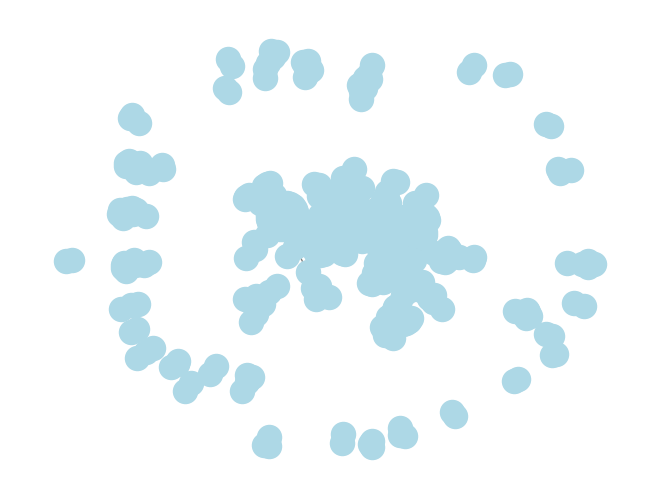

In [8]:
# visualize knowledge graph
nx.draw(G, with_labels=False, node_color='lightblue', edge_color='gray')
plt.show()

#### Entity deduplication from knowledge graph

In [9]:
# creating embedding from the nodes and their description
!ollama pull nomic-embed-text

lst = []
nodes_label_mapping_lst = []
for node in tqdm(G.nodes(data=True)):
    entity = "\nName: " + node[0] + " \nDescription: " + node[1]['description']
    embed = ollama.embeddings(model="nomic-embed-text", prompt=entity)['embedding']
    lst.append(embed)
    nodes_label_mapping_lst.append(node[0])

print(len(lst), len(nodes_label_mapping_lst))

  0%|          | 0/824 [00:00<?, ?it/s]

100%|██████████| 824/824 [00:16<00:00, 49.02it/s]

824 824


In [10]:
# creating adjacency matrix from the graph using a cutoff of 0.9 for cosine similarity
X = np.array(lst)
cosine_sim = cosine_similarity(X)
np.fill_diagonal(cosine_sim, 0)
cosine_sim = np.where(cosine_sim >= 0.9, 1, 0)

# creating adjacency list from above matrix
adjacency_list = defaultdict(list)
for i in range(cosine_sim.shape[0]):
    not_connected = True
    for j in range(cosine_sim.shape[0]):
        if cosine_sim[i,j]==1:
            not_connected = False
            adjacency_list[i].append(j)
    if not_connected:
        adjacency_list[i].append(i)

# creating list of connected nodes by clustering above connectivity data using BFS
connected_components = []
for key in adjacency_list.keys():
    if key not in [x for y in connected_components for x in y]:
        visited = []
        queue = [key]
        while len(queue)>0:
            node = queue.pop(0)
            if node not in visited:
                visited.append(node)
                for neighbour in adjacency_list[node]:
                    queue.append(neighbour)
        connected_components.append(visited)

nodes_to_merge_lst = [set(nodes_label_mapping_lst[y] for y in x) for x in connected_components]

# checking for duplicate entities
lst = []
for x in nodes_to_merge_lst:
    for y in x:
        assert y not in lst, f"Duplicate element found: {y}"
        lst.append(y)

# printing similar nodes
for x in nodes_to_merge_lst:
    if len(x)>1:
        print(x)

{'SCOPE 1 EMMISSION', 'SCOPE 1'}
{'C3.2A', 'C1.1A', 'C3.2, C3.2A, C3.2B', 'C1.1D', 'C3.2B', 'C1.1, C1.1A, C1.1B', 'C4.3B', 'C3.5A', 'C1.3A', 'C4.5, C4.5A', 'C1.3, C1.3A', 'C2.3A', 'C12.3,C12.3A TO B', 'C2.1A', 'C2.1B', 'C3.4, C3.5, C3.5A'}
{'CLIMATE-RELATED ISSUES', 'CLIMATE-RELATED RISKS AND OPPORTUNITIES', 'CLIMATE RELATED RISKS', 'CLIMATE-RELATED RISK', 'CLIMATE RELATED OPPORTUNITIES', 'CLIMATE RELATED RISKS AND OPPORTUNITIES'}
{'ZERO EMISSIONS MEDIUM- AND HEAVY-DUTY TRUCKS', 'HEAVY DUTY TRUCKS', 'HEAVY DUTY VEHICLES (HDV)', 'HEAVY DUTY VEHICLE', 'DIESEL HEAVY DUTY VEHICLES', 'MEDIUM- AND HEAVY-DUTY TRUCKS'}
{'SCIENCE-BASED TARGET', 'SCIENCE BASED TARGETS', 'SCIENCE BASED TARGETS INITIATIVE (SBTI)', 'SCIENCE BASED TARGETS (SBTS)', 'SCIENCE BASED TARGET INITIATIVE', 'SCIENCE-BASED TARGETS', 'SCIENCE BASED TARGETS INITIATIVE', 'SCIENCE-BASED TARGET INITIATIVE (SBTI)'}
{'COMPANY-WIDE', 'COMPANY INFORMATION', 'THE COMPANY', 'COMPANY'}
{'RISKS AND OPPORTUNITIES', 'RISK AND OPPORTUNITIES'

In [13]:
G_copy = copy.deepcopy(G)

for nodes_to_merge in nodes_to_merge_lst:
	if len(nodes_to_merge)>1:
		# Create a new node as the merged node
		merged_node = "\n".join(list(nodes_to_merge))
		G_copy.add_node(merged_node, description=set(), chunks=set())

		# Merge node properties
		for node in nodes_to_merge:
			if G_copy.has_node(node):
				node_data = G_copy.nodes[node]
				G_copy.nodes[merged_node]['description'].add(node_data.get('description'))
				G_copy.nodes[merged_node]['chunks'].update(node_data.get('chunks'))

		G_copy.nodes[merged_node]['chunks'] = list(G_copy.nodes[merged_node]['chunks'])
		G_copy.nodes[merged_node]['description'] = "\n".join(list(G_copy.nodes[merged_node]['description']))

		# Update edges
		for node1, node2, data in G.edges(data=True):
			if node1 in nodes_to_merge or node2 in nodes_to_merge:
				new_node1 = merged_node if node1 in nodes_to_merge else node1
				new_node2 = merged_node if node2 in nodes_to_merge else node2
				
				if new_node1 != new_node2:
					if G_copy.has_edge(new_node1, new_node2):
						existing_data = G_copy[new_node1][new_node2]
						existing_data['relationship'] += f"\n{data['relationship']}"
						existing_data['score'] = max(existing_data['score'], data['score'])
					else:
						G_copy.add_edge(new_node1, new_node2, relationship=data['relationship'], score=data['score'])

# Remove old nodes
for nodes_to_merge in nodes_to_merge_lst:
	if len(nodes_to_merge)>1:                  
		G_copy.remove_nodes_from(nodes_to_merge)

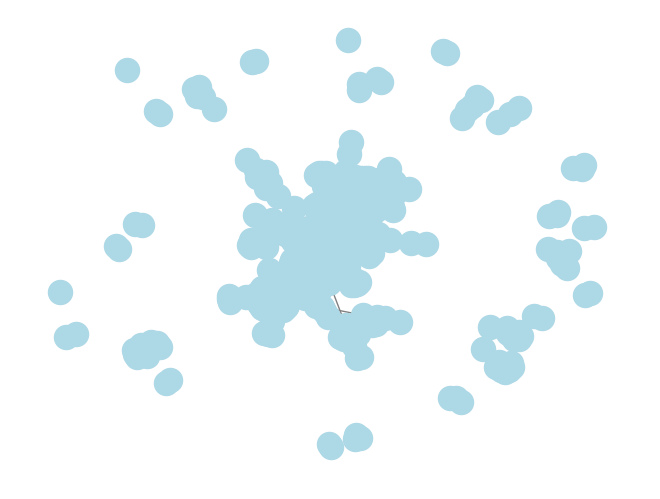

In [14]:
# visulaizing graph post merging
nx.draw(G_copy, with_labels=False, node_color='lightblue', edge_color='gray')
plt.show()

In [15]:
print(len(G.nodes), len(G_copy.nodes))

389 341


In [16]:
# checking if merging has been successful
assert len(G.nodes) - len([y for x in nodes_to_merge_lst for y in x if len(x)>1]) + \
    len([x for x in nodes_to_merge_lst if len(x)>1]) == len(G_copy.nodes), "Merging not sucessful"

In [17]:
# deleting earlier graph
del G
G = G_copy

#### Node Description and relationship summarization

In [18]:
# summarizing node description
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

for node, data in tqdm(G.nodes(data=True)):
    if len(encoding.encode(data['description']))>300:
        print(f"Description summerized for Node_{node}")
        prompt = ENTITY_DESCRIPTION_SUMMARIZATION_PROMPT.replace("{entity_name}", node)
        prompt = prompt.replace("{description_list}", str([data['description']]))
        desc = await client.chat.completions.create(
                                    model="gpt-35-turbo-16k",
                                    temperature=0.1,
                                    messages=[{"role": "user", "content": prompt}],
                                    stream=False
                                )
        desc = desc.choices[0].message.content
        data['description'] = desc

100%|██████████| 341/341 [00:00<?, ?it/s]


In [19]:
# summarizing relationship description
for node1, node2, data in tqdm(G.edges(data=True)):
    if len(encoding.encode(data['relationship']))>300:
        print(f"Relationship summerized bw Node1 ({node1}) and Node2 ({node2})")
        prompt = RELATIONSHIP_SUMMARIZATION_PROMPT.replace("{entity_name1, entity_name2}", f"{node1}, {node2}")                                                          
        prompt = prompt.replace("{relationships_list}", str([data['relationship']]))
        desc = await client.chat.completions.create(
                                    model="gpt-35-turbo-16k",
                                    temperature=0.1,
                                    messages=[{"role": "user", "content": prompt}],
                                    stream=False
                                )
        desc = desc.choices[0].message.content
        data['relationship'] = desc

100%|██████████| 365/365 [00:00<00:00, 38426.73it/s]


#### Creating communities

In [20]:
# creating hierarchial clusters using community detection algo
assert np.sum(np.tril(np.array(nx.adjacency_matrix(G).todense())) == 1) == len(G.edges) , \
                                                                "some issue in adjacency matrix"

communities = hierarchical_leiden(G, max_cluster_size=10)

lst = [x.node for x in communities]
for node in G.nodes:
    if node not in lst:
        print(node)
        print("----")

MANUFACTURING CAPACITIES
MANUFACTURING CAPACITY
----
HERBICIDE FACILITY
HERBICIDE MANUFACTURING FACILITY
----
ZERO LIQUID DISCHARGE
ZERO-LIQUID DISCHARGE (ZLD)
----


c:\Users\soumya_chakraborty\Anaconda3\envs\LLM\lib\site-packages\graspologic\partition\leiden.py:607: UserWarning: Leiden partitions do not contain all nodes from the input graph because input graph contained isolate nodes.
  warnings.warn(


#### Generating community summaries

In [21]:
# creating prompt for community summarization
def community_summary_prompt_generator(cluster_id, cluster_nodes):
    cluster_info = {
      "communityId": cluster_id,
      "nodes": [],
      "relationships": []
    }

    for node in cluster_nodes:
      node_data = G.nodes[node]
      node_info = {
        "id": node,
        "description": node_data["description"]
      }
      cluster_info["nodes"].append(node_info)

    for node1, node2, data in G.edges(data=True):
      if node1 in cluster_nodes and node2 in cluster_nodes:
        relationship_info = {
          "start": node1,
          "description": data["relationship"],
          "end": node2
        }
        cluster_info["relationships"].append(relationship_info)

    return cluster_info

In [22]:
# generating community summaries
node_cluster_dct = defaultdict(list)
for community in communities:
    node_cluster_dct[community.node].append((community.cluster, community.level))

cluster_node_dct = defaultdict(list)
for community in communities:
    cluster_node_dct[community.cluster].append(community.node)

community_summary = {}
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
for key, val in tqdm(cluster_node_dct.items()):
    prompt = COMMUNITY_SUMMARIZATION_PROMPT.replace("{community_info}", 
                                                    str(community_summary_prompt_generator(key, val)))
    if len(encoding.encode(prompt))>10000:
        prompt = " ".join(prompt.split()[:10000])
        print(f"prompt truncated for Cluster_{key}")
    
    summary = await client.chat.completions.create(
            model="gpt-35-turbo-16k",
            temperature=0.1,
            messages=[{"role": "user", "content": prompt}],
            stream=False
        )
    
    community_summary[key] = summary.choices[0].message.content

100%|██████████| 76/76 [04:15<00:00,  3.36s/it]


In [23]:
# storing all community summaries at different heirarchial level for each node
for node, data in tqdm(G.nodes(data=True)):
    if node in node_cluster_dct.keys():
        node_level_summary = []
        for level in sorted(list(set([x[1] for x in node_cluster_dct[node]]))):
            associated_communities = [y for y in node_cluster_dct[node] if y[1]==level]
            associated_communities_summaries = [community_summary[y[0]] for y in associated_communities]
            node_level_summary.append(("\n".join(associated_communities_summaries), level))
        data["community_summaries"] = [y[0] for y in sorted(node_level_summary, key = lambda x:x[1], reverse=True)]
    else:
        data["community_summaries"] = " "

100%|██████████| 341/341 [00:00<00:00, 341350.28it/s]


#### Creating node embeddings

In [4]:
!ollama pull nomic-embed-text

pulling manifest ⠋ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠧ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠴ pulling manifest ⠧ pulling manifest ⠧ pulling manifest ⠏ pulling manifest ⠏ pulling manifest 
pulling 970aa74c0a90... 100% ▕████████████████▏ 274 MB                         pulling manifest 
pulling 970aa74c0a90... 100% ▕████████████████▏ 274 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling ce4a164fc046... 100% ▕████████████████▏   17 B                         
pulling 31df23ea7daa... 100% ▕████████████████▏  420 B                         
verifying sha256 digest 
writing manifest 
removing any unused layers 
success 


In [5]:
embeddings = OllamaEmbeddings(model="nomic-embed-text")

In [6]:
# store node embeddings in vector database
docs = []
for node, data in tqdm(G.nodes(data=True)):
    entity = "\nName: " + node + " \nDescription: " + data['description']
    doc = Document(
    page_content=entity,
    metadata={"source": node}
    )
    docs.append(doc)

embedding_function = OllamaEmbeddings(model="nomic-embed-text")
db = Chroma.from_documents(docs, embedding_function)

100%|██████████| 593/593 [00:00<00:00, 62902.36it/s]

In [27]:
# save Knowledge graph created in json
with open("graph.json", "w") as f:
    json.dump(json_graph.node_link_data(G), f)

In [3]:
# load knowledge graph
G = nx.Graph()

with open("graph.json", "r") as f:
    G_data = json.load(f)
    G = json_graph.node_link_graph(G_data)

#### Querying

In [111]:
query = '''Write a summary of scope 1 and scope 3 emission related to target Baseline Year, target end/horizon year,
percentage reduction. Give output in a json format.'''
topk_nodes=12
topk_chunks = 12
topk_internal_rel = 12
topk_external_rel = 12
nodes = db.similarity_search(query,topk_nodes)

In [112]:
nodes

[Document(metadata={'source': 'BASE YEAR EMISSIONS COVERED BY TARGET IN ALL SELECTED SCOPES AS % OF TOTAL BASE YEAR EMISSIONS IN ALL SELECTED SCOPES\nBASE YEAR TOTAL SCOPE 3 EMISSIONS COVERED BY TARGET AS % OF TOTAL BASE YEAR EMISSIONS IN SCOPE 3 (IN ALL SCOPE 3 CATEGORIES)'}, page_content='\nName: BASE YEAR EMISSIONS COVERED BY TARGET IN ALL SELECTED SCOPES AS % OF TOTAL BASE YEAR EMISSIONS IN ALL SELECTED SCOPES\nBASE YEAR TOTAL SCOPE 3 EMISSIONS COVERED BY TARGET AS % OF TOTAL BASE YEAR EMISSIONS IN SCOPE 3 (IN ALL SCOPE 3 CATEGORIES) \nDescription:  '),
 Document(metadata={'source': 'IEA WB2C AND B2DS TRAJECTORY THROUGH 2060'}, page_content='\nName: IEA WB2C AND B2DS TRAJECTORY THROUGH 2060 \nDescription:  '),
 Document(metadata={'source': 'TOTAL SCOPE 3 EMISSIONS\nSCOPE 3 PRODUCT-USE EMISSIONS\nSCOPE 3 EMISSIONS'}, page_content='\nName: TOTAL SCOPE 3 EMISSIONS\nSCOPE 3 PRODUCT-USE EMISSIONS\nSCOPE 3 EMISSIONS \nDescription:  '),
 Document(metadata={'source': '% CHANGE ANTICIPATED 

In [113]:
# getting associated text chunks
chunks = []
query_embed = ollama.embeddings(model="nomic-embed-text", prompt=query)['embedding']
for node in nodes:
    chunks.extend(G.nodes[node.metadata["source"]]['chunks'])

chunks = list(set(chunks))
chunks_selected = chunks
len(chunks_selected)

22

In [114]:
# getting top k internal and external relationships 
within_relationships = []
between_relationships = []
nodes_info = []
nodes_set = set([x.metadata["source"] for x in nodes])

for node1, node2, data in G.edges(data=True):
    relationship_info = {
        "start": node1,
        "end": node2,
        "description": data["relationship"],
        "score": data["score"]
    }
    if node1 in nodes_set and node2 in nodes_set:
        within_relationships.append(relationship_info)
    elif (node1 in nodes_set and node2 not in nodes_set) or (node2 in nodes_set and node1 not in nodes_set):
        between_relationships.append(relationship_info)

within_relationships = sorted(within_relationships, key=lambda x: x["score"], reverse=True)[:topk_internal_rel]
between_relationships = sorted(between_relationships, key=lambda x: x["score"], reverse=True)[:topk_external_rel]

all_nodes = set()
relationships = within_relationships + between_relationships

for rel in relationships:
    all_nodes.add(rel["start"])
    all_nodes.add(rel["end"])

for node in all_nodes:
    if node in G.nodes:
        node_data = G.nodes[node]
        node_info = {
            "id": node,
            "description": node_data["description"]
        }
        nodes_info.append(node_info)

relationships_selected = {
    "nodes": nodes_info,
    "relationships": relationships
}

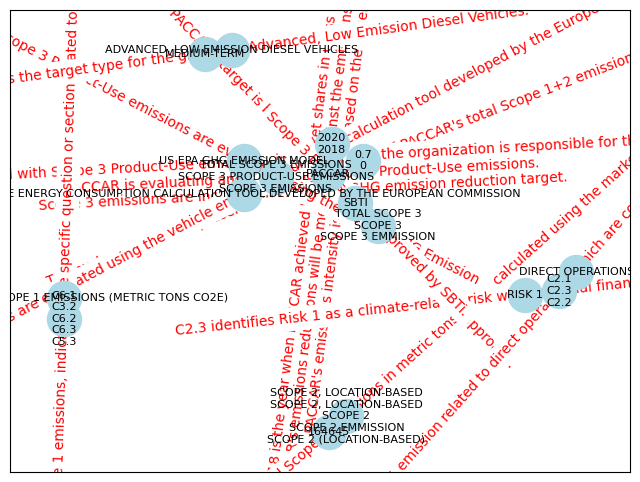

In [115]:
# visualizing extracted graph
G1 = nx.Graph()

for x in relationships_selected['relationships']:
    if x['start'] not in list(G.nodes):
        G1.add_node(x['start'])
    if x['end'] not in list(G.nodes):
        G1.add_node(x['end'])
    G1.add_edge(x['start'], x['end'], relationship=x['description'])

pos = nx.spring_layout(G1)

plt.figure(figsize=(8, 6))

nx.draw_networkx_nodes(G1, pos, node_color='lightblue', node_size=600)
nx.draw_networkx_labels(G1, pos, font_size=8)

nx.draw_networkx_edges(G1, pos, arrows=True)
edge_labels = nx.get_edge_attributes(G1, 'relationship')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels, font_color='red')

plt.show()

In [116]:
# getting immediate summaries
summaries_selected = []
for node in nodes:
    summaries_selected.append(G.nodes[node.metadata["source"]]['community_summaries'][0])

len(summaries_selected)

12

In [117]:
# generating prompt
context = "CHUNK TEXT: \n" + "\n".join(chunks_selected) + \
        "\n\nNODES: \n" + str(relationships_selected["nodes"]) + \
        "\n\nRELATIONSHIPS: \n" + str(relationships_selected["relationships"]) + \
        "\n\nCUMMUNITY SUMMARIES: \n" + str(summaries_selected)

prompt = PREDICTION_PROMPT.replace("{question}", query)
prompt = prompt.replace("{context}", context)

In [118]:
print(prompt)


You are an helpful Question Answering AI assistant based on the relevant context provided.
In the context, you are provide informations of some text chunks. Along with that you are also provided information about nodes, relationships and community summaries of the nodes extracted from a relevant portion of knowledge graph according to the question asked. The information is provided in the below format:
CHUNK TEXT: Text chunks provided 


NODES : Information about nodes having "id" and "node description" 


RELATIONSHIPS : Relationpships between the nodes contating "start" and "end" node along with their relationship as "description" 


CUMMUNITY SUMMARIES: Community summaries of the nodes in a list.

#########################################################
Answer the question based on the above context provided and predict the most relevant answer.

Context: CHUNK TEXT: 
Mgmt. 
Process for identifying and managing climate related risks and 
opportunities 
C2.1, C2.2 
Climate related 

In [119]:
# generating response
answer = await client.chat.completions.create(
            model="gpt-35-turbo-16k",
            temperature=0.1,
            messages=[{"role": "user", "content": prompt}],
            stream=False,
            seed=42
        )

answer.choices[0].message.content

'{\n  "Scope 1 Emission Summary": {\n    "Baseline Year": "2018",\n    "Target End/Horizon Year": "2030",\n    "Percentage Reduction": "35%"\n  },\n  "Scope 3 Emission Summary": {\n    "Baseline Year": "2018",\n    "Target End/Horizon Year": "2030",\n    "Percentage Reduction": "25%"\n  }\n}'